In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('UCI Fraudulent firm classification').getOrCreate()

In [2]:
trial  = spark.read.csv('trial.csv', inferSchema = True, header = True)

In [3]:
trial.printSchema()

root
 |-- Sector_score: double (nullable = true)
 |-- LOCATION_ID: string (nullable = true)
 |-- PARA_A: double (nullable = true)
 |-- SCORE_A: integer (nullable = true)
 |-- PARA_B: double (nullable = true)
 |-- SCORE_B: integer (nullable = true)
 |-- TOTAL: double (nullable = true)
 |-- numbers: double (nullable = true)
 |-- Marks: integer (nullable = true)
 |-- Money_Value: double (nullable = true)
 |-- MONEY_Marks: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Loss: integer (nullable = true)
 |-- LOSS_SCORE: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- History_score: integer (nullable = true)
 |-- Score: double (nullable = true)
 |-- Risk: integer (nullable = true)



In [4]:
trial.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Sector_score,776,20.184536082474136,24.319017128722187,1.85,59.85
LOCATION_ID,776,14.856403622250971,9.891317488621631,1,SAFIDON
PARA_A,776,2.450194072164947,5.678870370534314,0.0,85.0
SCORE_A,776,3.5128865979381443,1.7405490917155328,2,6
PARA_B,776,10.799988402061862,50.0836236086675,0.0,1264.63
SCORE_B,776,3.131443298969072,1.6980416741362467,2,6
TOTAL,776,13.218481443298984,51.31282925864575,0.0,1268.91
numbers,776,5.067654639175258,0.26444862039735334,5.0,9.0
Marks,776,2.2371134020618557,0.8035173756240932,2,6


In [5]:
trial.dtypes


[('Sector_score', 'double'),
 ('LOCATION_ID', 'string'),
 ('PARA_A', 'double'),
 ('SCORE_A', 'int'),
 ('PARA_B', 'double'),
 ('SCORE_B', 'int'),
 ('TOTAL', 'double'),
 ('numbers', 'double'),
 ('Marks', 'int'),
 ('Money_Value', 'double'),
 ('MONEY_Marks', 'int'),
 ('District', 'int'),
 ('Loss', 'int'),
 ('LOSS_SCORE', 'int'),
 ('History', 'int'),
 ('History_score', 'int'),
 ('Score', 'double'),
 ('Risk', 'int')]

In [6]:
trial= trial.na.fill(0)

In [7]:
trial.columns

['Sector_score',
 'LOCATION_ID',
 'PARA_A',
 'SCORE_A',
 'PARA_B',
 'SCORE_B',
 'TOTAL',
 'numbers',
 'Marks',
 'Money_Value',
 'MONEY_Marks',
 'District',
 'Loss',
 'LOSS_SCORE',
 'History',
 'History_score',
 'Score',
 'Risk']

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler


In [9]:
# Transform all features into a vector using VectorAssembler

assemblerInputs = [ 'Sector_score',
 'PARA_A',
 'SCORE_A',
 'PARA_B',
 'SCORE_B',
 'TOTAL',
 'numbers',
 'Marks',
 'Money_Value',
 'MONEY_Marks',
 'District',
 'Loss',
 'LOSS_SCORE',
 'History',
 'History_score',
 'Score',] 

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [10]:
standardScaler = StandardScaler(inputCol="features", outputCol="scaled_features")


In [11]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import ChiSqSelector

from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml import Pipeline


rf = RandomForestClassifier(labelCol="Risk", featuresCol="scaled_features", seed = 72,
                            numTrees=10, cacheNodeIds = True)

#from pyspark.ml.classification import LogisticRegression


In [12]:
pipeline = Pipeline(stages=[assembler, standardScaler, rf])

In [13]:
train, test = trial.randomSplit([0.7, 0.3], seed = 42)


In [14]:
fit_model = pipeline.fit(train)

In [15]:
fit_model.stages[:]

[VectorAssembler_11a56d2a33b2,
 StandardScaler_62843cae57e2,
 RandomForestClassificationModel (uid=RandomForestClassifier_20f82e9ff082) with 10 trees]

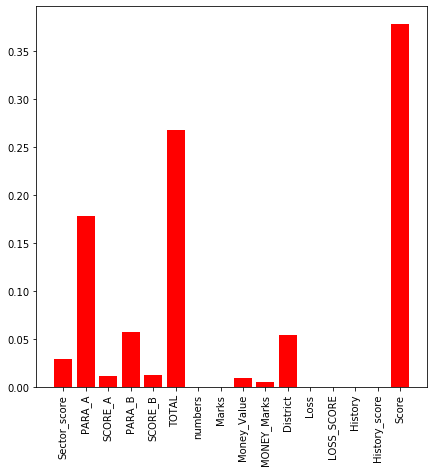

In [18]:
#Feature Importance
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.bar(assemblerInputs, list(fit_model.stages[-1].featureImportances), color='red')
plt.xticks(rotation=90)

plt.show()

In [19]:
results = fit_model.transform(test)

In [21]:
import pandas as pd
importance_list = pd.Series(list(fit_model.stages[-1].featureImportances))
main_features = []
importance_list
for index, value in enumerate(importance_list):
    if value>0.03:
        main_features.append(assemblerInputs[index])
main_features
    

['PARA_A', 'PARA_B', 'TOTAL', 'District', 'Score']

In [23]:
results.select("features","scaled_features").toPandas().head()

,features,scaled_features
0,"[1.85, 1.69, 4.0, 0.21, 2.0, 1.9, 5.0, 2.0, 0....","[0.07647437986638064, 0.3029177315923537, 2.28..."
1,"[1.85, 10.02, 6.0, 0.95, 2.0, 10.97, 5.0, 2.0,...","[0.07647437986638064, 1.795997438198452, 3.433..."
2,"[1.85, 0.6, 2.0, 1.14, 4.0, 1.74, 5.0, 2.0, 0....","[0.07647437986638064, 0.10754475677835042, 1.1..."
3,"[1.85, 9.94, 6.0, 0.44, 2.0, 10.38, 5.0, 2.0, ...","[0.07647437986638064, 1.781658137294672, 3.433..."
4,"[1.85, 3.83, 6.0, 0.28, 2.0, 4.11, 5.0, 2.0, 0...","[0.07647437986638064, 0.6864940307684703, 3.43..."


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [25]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Risk')

In [26]:
my_eval.evaluate(results, {my_eval.metricName: 'areaUnderROC'})

1.0